Tutorial Sourced from: https://github.com/mbakker7/ttim

# HowTo: Pumping test analysis with `ttim`
 
This HowTo describes how to use `ttim` for pumping test analysis (also called aquifer test analysis).
A simple pumping test is analyzed in this Notebook. A whole series of notebooks with examples of pumping test analyses are listed under the 'pumping test benchmark' section of the ReadTheDocs. 

We start by importing the required packages:

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

import ttim as ttm

# Set some custom parameters for matplotlib graphs
plt.rcParams["figure.figsize"] = (4, 3)  # set default figure size
plt.rcParams["font.size"] = 8  # set default font size

# Where are we working from
os.getcwd()

'c:\\Users\\Anton\\OneDrive\\Code\\PythonForHydrogeologists\\examples\\AnalyticElement'

We analyze pumping test data from a pumping test carried out near the *Oude Korendijk* in The Netherlands, as described in the famous book on pumping tests by Kruseman and de Ridder (downloadable [here](https://gw-project.org/download/analysis-and-evaluation-of-pumping-test-data/)). The pumping test was carried out in a 7 m thick, confined aquifer with the top at $z_t=-18$ m and the bottom at $z_b=-25$ m. The objective of the pumping test was to determine the hydraulic conductivity and specific storage coefficient of the aquifer.  The discharge of the well during the pumping test was 788 m<sup>3</sup>/day. The observed drawdown (in meters) and the observation time (in minutes) after pumping started were measured in two observations wells, one located 30 m from the pumping well and the other located 90 m from the pumping well. Kruseman and de Ridder (1990) also report drawdown in an additional well, but that one is not considered here. 

The time (in minutes) and drawdown (in meters) of the two wells are stored in the files `data/oudekorendijk_h30.dat` and `data/oudekorendijk_h90.dat`, respectively. The time and head are read from the data files. The time is converted to days and the drawdown is converted to meters, after which the data is plotted.

first measurement time: 6.94e-05, last measurement time: 5.76e-01 d
first measurement time: 1.04e-03, last measurement time: 5.87e-01 d


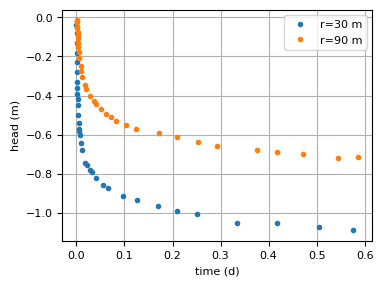

In [2]:
data = np.loadtxt(r".\data\oudekorendijk_h30.dat")
to1 = data[:, 0] / 60 / 24
ho1 = -data[:, 1]
ro1 = 30
print(
    f"first measurement time: {np.min(to1):.2e}, "
    f"last measurement time: {np.max(to1):.2e} d"
)

drawdown = np.loadtxt(r".\data\oudekorendijk_h90.dat")
to2 = drawdown[:, 0] / 60 / 24
ho2 = -drawdown[:, 1]
ro2 = 90
print(
    f"first measurement time: {np.min(to2):.2e}, "
    f"last measurement time: {np.max(to2):.2e} d"
)

plt.plot(to1, ho1, "C0.", label="r=30 m")
plt.plot(to2, ho2, "C1.", label="r=90 m")
plt.xlabel("time (d)")
plt.ylabel("head (m)")
plt.legend()
plt.grid()

A pumping test analysis with `ttim` consists of the following steps:
1. Create a `ttim` model using your best guess of the parameters.
2. Create a `Calibrate object`
3. Specify which parameters you want to estimate.
4. Specify which time serie(s) you want to use to estimate the parameters.
5. Estimate the parameters

The parameters are fitted using the least squares method. An iterative approach is used to find the optimal parameters. The iterative approach is pretty fancy, but no iterative method is foolproof. The better your guess of the parameters, the higher the likelihood that the iterative method will find the optimal parameters (no pun intended). 

We creat a model for a single confined aquifer. The initial guess is that the hydraulic conductivity is k=20 m/d and the specific storage coefficient is S_s=10<sup>-4</sup> m<sup>-1</sup>. `tmin` and `tmax` are set to cover all observation times. One well is added with a discharge of 788 m<sup>3</sup>/d. No recovery was measured, so the well does not have to be shut off. Wellbore storage is not simulated. The model is solved. As a check, the head is plotted vs. the observations. This confirms that the model runs. As can be seen, the initial guess is not bad, but obviously not optimal. 

In [3]:
ml = ttm.ModelMaq(kaq=60, z=(-18, -25), Saq=1e-4, tmin=1e-5, tmax=1)
w = ttm.Well(model=ml, xw=0, yw=0, rw=0.1, tsandQ=[(0, 788)], layers=0)
ml.solve()

self.neq  1
solution complete


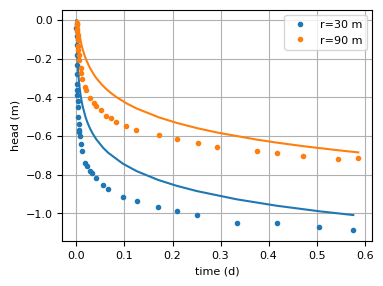

In [4]:
hm1 = ml.head(ro1, 0, to1)
hm2 = ml.head(ro2, 0, to2)
plt.plot(to1, ho1, "C0.", label="r=30 m")
plt.plot(to1, hm1[0], "C0")
plt.plot(to2, ho2, "C1.", label="r=90 m")
plt.plot(to2, hm2[0], "C1")
plt.xlabel("time (d)")
plt.ylabel("head (m)")
plt.legend()
plt.grid()

Steps 2-5 are conducted in the next code block. At first, only the observations in the first well (at 30 m from the pumping well) are used for calibration.

2. The `Calibration` object is created for the model `ml` (which was created above). The `Calibration` object is stored in the variable `cal`. 
3. It is specified that the `Calibration` object must fit for the hydraulic conductivity of layer 0 by using the `set_parameter` function. The name of the parameters is `kaq` (the same name as used to create the `ttim` model) and the `0` is added to indicate that it is the hydraulic conductivity of layer 0. Furthermore, the initial value is specified. Again, use your best guess. Next, it is specified to fit for the specific discharge of layer 0 in the same fashio. The name of the parameter is `Saq` (again, the same name as used to create the `ttim` model) and the `0` is added to indicate layer 0. 
4. It is specified to use the times and heads of the observation well at r=30 m using the `series` function. The `series` function takes a name (use whatever name you like to identify this observation well), the `x` and `y` location of the well, the layer number, an array of the observation times and an array of the observed heads.
5. Find the optimal parameters using the `fit` function. A dot is printed to the screen every time the model is solved with a new set of parameters during the iterative optimization approach. 

In [5]:
cal = ttm.Calibrate(model=ml)  # create Calibration object
cal.set_parameter(name="kaq0", initial=20)  #
cal.set_parameter(name="Saq0", initial=1e-4)
cal.series(
    name="obs1",  # user specified name
    x=ro1,  # x=location of observation well
    y=0,  # y-location of obsevation well
    layer=0,  # layer number
    t=to1,  # observation times
    h=ho1,  # observed heads
)
cal.fit(report=False)

C:\Users\Anton\AppData\Local\Temp\ipykernel_65420\178102974.py:2: DeprecationWarning: Setting layers in the parameter name is deprecated. Set the layers= keyword argument for parameter 'kaq0' to silence this warning. The parameter name can still include layer info, but this will be ignored in a future version of TTim.
  cal.set_parameter(name="kaq0", initial=20)  #
C:\Users\Anton\AppData\Local\Temp\ipykernel_65420\178102974.py:3: DeprecationWarning: Setting layers in the parameter name is deprecated. Set the layers= keyword argument for parameter 'Saq0' to silence this warning. The parameter name can still include layer info, but this will be ignored in a future version of TTim.
  cal.set_parameter(name="Saq0", initial=1e-4)


.........................
Fit succeeded.


A good approach to print the fitted parameters to the screen is to display the `cal.parameters` `DataFrame`. Note that the estimated standard error (the column `std`) is **not** a very good estimate of the standard error, as the remaining errors rarely statisfy the required statistical conditions for such an estimate of the standard error.

In [6]:
display(cal.parameters)

,layers,optimal,std,perc_std,pmin,pmax,initial,inhoms,parray
kaq0,None,68.639639,1.438179,2.095261,-inf,inf,20.0000,None,[[68.63963937481454]]
Saq0,None,0.000016,0.000002,9.844457,-inf,inf,0.0001,None,[[1.6071286825168125e-05]]


The optimal parameters are also automatically stored in the model:

In [7]:
print("k of model: ", ml.aq.kaq)
print("Ss of model: ", ml.aq.Saq)

k of model:  [68.63963937]
Ss of model:  [1.60712868e-05]


Hence, a graph of the model fit can be created in the same fashion as before. Note that the fit for the observations at $r=30$ m is indeed a lot better than with our initial guess.

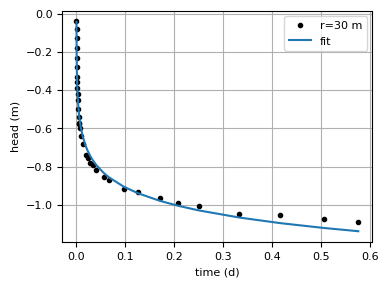

In [8]:
hm1 = ml.head(ro1, 0, to1)
plt.plot(to1, ho1, "k.", label="r=30 m")
plt.plot(to1, hm1[0], "C0", label="fit")
plt.xlabel("time (d)")
plt.ylabel("head (m)")
plt.legend()
plt.grid()

The model with the optimal parameters deviates significantly from the obervations at larger times. Maybe the confining top layer can not be simulated as impereable. Let's modify the model and replace the confined aquifer by a semi-confined aquifer. The new model is called `ml2`. The thickness of the semi-confining layer is set to 1 (i.e., `z` goes from -17 to -18) and the initial guess for the resistance of the semi-confining layer is 1000 days (aquitard thickness * aquitard vertical hydraulic conductivity). Storage in the semi-confining layer is negelected. A new calibration object is created, which is used now to fit three parameters. The additional parameter is called `'c0'`, which stands for the resistance of leaky layer 0, which is on top of aquifer layer 0. Note that the optimal hydraulic conductivity is now more than 10% lower than for the confined aquifer. 

In [9]:
ml2 = ttm.ModelMaq(
    kaq=60,
    z=(-17, -18, -25),
    Saq=1e-4,
    c=[1000],
    Sll=0,
    topboundary="semi",
    tmin=1e-5,
    tmax=1,
)
w = ttm.Well(model=ml2, xw=0, yw=0, rw=0.1, tsandQ=[(0, 788)], layers=0)
ml2.solve()
#
cal2 = ttm.Calibrate(model=ml2)  # create Calibration object
cal2.set_parameter(name="kaq0", initial=20)  #
cal2.set_parameter(name="Saq0", initial=1e-4)
cal2.set_parameter(name="c0", initial=1000)
cal2.series(
    name="obs1",  # user specified name
    x=ro1,  # x=location of observation well
    y=0,  # y-location of obsevation well
    layer=0,  # layer number
    t=to1,  # observation times
    h=ho1,  # observed heads
)
cal2.fit(report=False)
display(cal2.parameters)

self.neq  1
solution complete
...........................................


C:\Users\Anton\AppData\Local\Temp\ipykernel_65420\260777633.py:15: DeprecationWarning: Setting layers in the parameter name is deprecated. Set the layers= keyword argument for parameter 'kaq0' to silence this warning. The parameter name can still include layer info, but this will be ignored in a future version of TTim.
  cal2.set_parameter(name="kaq0", initial=20)  #
C:\Users\Anton\AppData\Local\Temp\ipykernel_65420\260777633.py:16: DeprecationWarning: Setting layers in the parameter name is deprecated. Set the layers= keyword argument for parameter 'Saq0' to silence this warning. The parameter name can still include layer info, but this will be ignored in a future version of TTim.
  cal2.set_parameter(name="Saq0", initial=1e-4)
C:\Users\Anton\AppData\Local\Temp\ipykernel_65420\260777633.py:17: DeprecationWarning: Setting layers in the parameter name is deprecated. Set the layers= keyword argument for parameter 'c0' to silence this warning. The parameter name can still include layer in

Fit succeeded.


,layers,optimal,std,perc_std,pmin,pmax,initial,inhoms,parray
kaq0,None,59.400250,1.212779,2.041707,-inf,inf,20.0000,None,[[59.400249547052326]]
Saq0,None,0.000022,0.000001,5.811261,-inf,inf,0.0001,None,[[2.2296800889516132e-05]]
c0,None,2084.729891,376.103642,18.040881,-inf,inf,1000.0000,None,[[2084.7298914884464]]


The fit of the two models can be compared visually:

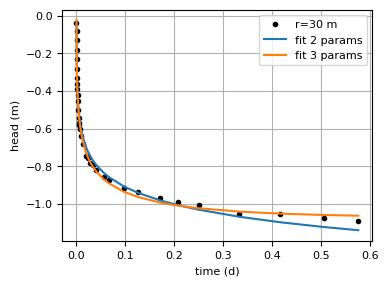

In [10]:
hm1 = ml.head(ro1, 0, to1)
hm2 = ml2.head(ro1, 0, to1)
plt.plot(to1, ho1, "k.", label="r=30 m")
plt.plot(to1, hm1[0], label="fit 2 params")
plt.plot(to1, hm2[0], label="fit 3 params")
plt.xlabel("time (d)")
plt.ylabel("head (m)")
plt.legend()
plt.grid()

Or the fit of the two models can be compared by computing the root mean squared error for the two models. Note that addition of the semi-confining layer almost halved the root mean squared error. 

In [11]:
print(f"rmse 2 params: {cal.rmse():.3f} m")
print(f"rmse 3 params: {cal2.rmse():.3f} m")

rmse 2 params: 0.032 m
rmse 3 params: 0.017 m


The root mean squared error can be computed with the `rmse` function

Finally, the two models are fitted to the observations in both observation wells. This is done by adding a second series to both `cal` and `cal2` and re-fitting the model. The root mean squared error are printed to the screen and graphs of the model fit are produced.

In [12]:
cal.series(
    name="obs2",  # user specified name
    x=ro2,  # x=location of observation well
    y=0,  # y-location of obsevation well
    layer=0,  # layer number
    t=to2,  # observation times
    h=ho2,  # observed heads
)
cal.fit(report=False)
display(cal.parameters)

......................
Fit succeeded.


,layers,optimal,std,perc_std,pmin,pmax,initial,inhoms,parray
kaq0,None,66.088743,1.654941,2.504119,-inf,inf,20.0000,None,[[66.08874328532666]]
Saq0,None,0.000025,0.000002,9.451573,-inf,inf,0.0001,None,[[2.540966107416315e-05]]


In [13]:
cal2.series(
    name="obs2",  # user specified name
    x=ro2,  # x=location of observation well
    y=0,  # y-location of obsevation well
    layer=0,  # layer number
    t=to2,  # observation times
    h=ho2,  # observed heads
)
cal2.fit(report=False)
display(cal2.parameters)

..........................................
Fit succeeded.


,layers,optimal,std,perc_std,pmin,pmax,initial,inhoms,parray
kaq0,None,53.729952,1.005398,1.871207,-inf,inf,20.0000,None,[[53.72995212670868]]
Saq0,None,0.000032,0.000001,4.203134,-inf,inf,0.0001,None,[[3.157775543566803e-05]]
c0,None,1016.312786,108.332973,10.659413,-inf,inf,1000.0000,None,[[1016.312785994004]]


In [14]:
print(f"rmse 2 params: {cal.rmse():.3f} m")
print(f"rmse 3 params: {cal2.rmse():.3f} m")

rmse 2 params: 0.050 m
rmse 3 params: 0.025 m


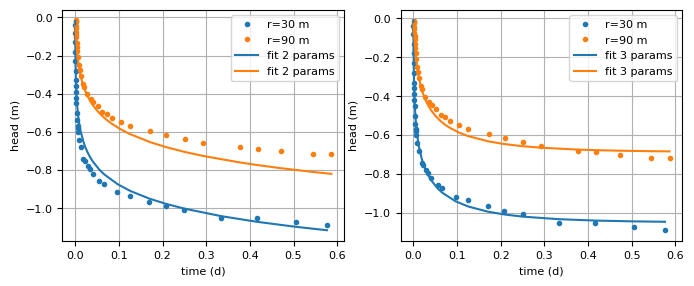

In [15]:
plt.figure(figsize=(8, 3))
plt.subplot(121)
hm1 = ml.head(ro1, 0, to1)
hm2 = ml.head(ro2, 0, to2)
plt.plot(to1, ho1, "C0.", label="r=30 m")
plt.plot(to2, ho2, "C1.", label="r=90 m")
plt.plot(to1, hm1[0], "C0", label="fit 2 params")
plt.plot(to2, hm2[0], "C1", label="fit 2 params")
plt.xlabel("time (d)")
plt.ylabel("head (m)")
plt.legend()
plt.grid()
#
plt.subplot(122)
hm1 = ml2.head(ro1, 0, to1)
hm2 = ml2.head(ro2, 0, to2)
plt.plot(to1, ho1, "C0.", label="r=30 m")
plt.plot(to2, ho2, "C1.", label="r=90 m")
plt.plot(to1, hm1[0], "C0", label="fit 3 params")
plt.plot(to2, hm2[0], "C1", label="fit 3 params")
plt.xlabel("time (d)")
plt.ylabel("head (m)")
plt.legend()
plt.grid()

Insight of the model fit can also be gained by plotting the results on semi-log graph.

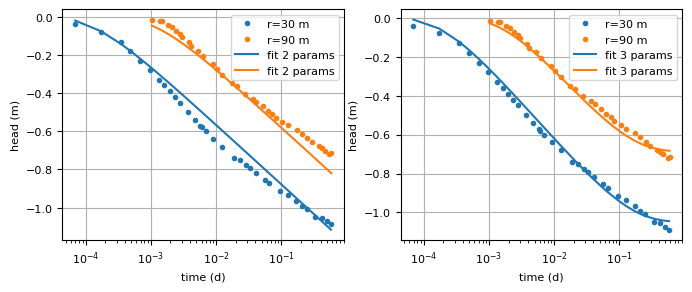

In [16]:
plt.figure(figsize=(8, 3))
plt.subplot(121)
hm1 = ml.head(ro1, 0, to1)
hm2 = ml.head(ro2, 0, to2)
plt.semilogx(to1, ho1, "C0.", label="r=30 m")
plt.semilogx(to2, ho2, "C1.", label="r=90 m")
plt.semilogx(to1, hm1[0], "C0", label="fit 2 params")
plt.semilogx(to2, hm2[0], "C1", label="fit 2 params")
plt.xlabel("time (d)")
plt.ylabel("head (m)")
plt.legend()
plt.grid()
#
plt.subplot(122)
hm1 = ml2.head(ro1, 0, to1)
hm2 = ml2.head(ro2, 0, to2)
plt.semilogx(to1, ho1, "C0.", label="r=30 m")
plt.semilogx(to2, ho2, "C1.", label="r=90 m")
plt.semilogx(to1, hm1[0], "C0", label="fit 3 params")
plt.semilogx(to2, hm2[0], "C1", label="fit 3 params")
plt.xlabel("time (d)")
plt.ylabel("head (m)")
plt.legend()
plt.grid()

It is now up to the modeler to decide which model is better and whether a semi-confined aquifer is more realistic than a confined aquifer. The model with 3 parameters gives a better fit in terms of the root mean squared error, but the behavior for large time deviates from the observations: the observed heads seem to go down with time in the semi-log graphs, but the modeled heads seem to level off for large time.